In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_25/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.42135% 	8.73983% 	0.04888		0.04398		0.0		1.0	
(1024,256) 	95.4% 		0.52776% 	6.36217% 	0.82382		0.83219		3e-05		0.98864	
(1024,1024) 	3.04% 		1.89917% 	2.20022% 	0.02452		0.00225		0.0		0.50979	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 1.00000 1.00000 0.00000 	(213910, 0.9037879560274013) 0.91123 0.90379 0.00744 	(688427, 0.938751472320377) 0.00509 0.93875 0.93366 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.90220 0.89420 0.00800 	(4240, 0.9623085983510011) 0.16509 0.96231 0.79722 	
(2436, 1.0) 0.76058 1.00000 0.23942 	(44828, 0.8401417658060423) 0.88693 0.84014 0.04679 	(694929, 0.9799764428739693) 0.00189 0.97998 0.97809 	
(55808, 1.0) 0.92141 1.00000 0.07859 	(232148, 0.8783613613364569) 0.89130 0.87836 0.01293 	(600540, 0.5747938751472321) 0.00178 0.57479 0.57302 	
(44159, 1.0) 0.99577 1.00000 0.00423 	(106790, 0.8420843224691953) 0.87690 0.84208 0.03482 	(226406, 0.8680800942285042) 0.04332 0.86808 0.82476 	
(25344, 1.0) 0.99995 1.00000 0.00005 	(155900, 0.8219974944514251) 0.84375 0.82200 0.02176 	(122896, 0.99528857

(27146, 1.0) 0.99999 1.00000 0.00001 	(146390, 0.9183938895737176) 0.90172 0.91839 0.01668 	(56379, 0.9587750294464076) 0.15853 0.95878 0.80024 	
(9216, 1.0) 0.99930 1.00000 0.00070 	(214211, 0.9035389311643356) 0.91978 0.90354 0.01624 	(52399, 0.8244994110718493) 0.10252 0.82450 0.72198 	
(9001, 1.0) 0.99157 1.00000 0.00843 	(32555, 0.759962800478216) 0.80677 0.75996 0.04681 	(484534, 0.9681978798586572) 0.02779 0.96820 0.94041 	
(23937, 1.0) 0.99973 1.00000 0.00027 	(112363, 0.9323265197747835) 0.92603 0.93233 0.00630 	(572502, 0.7962308598351) 0.04358 0.79623 0.75265 	
(3712, 1.0) 0.99153 1.00000 0.00847 	(202386, 0.8547444588701087) 0.87288 0.85474 0.01814 	(551702, 0.9375736160188458) 0.00049 0.93757 0.93709 	
(56196, 1.0) 0.99855 1.00000 0.00145 	(211174, 0.8623937046282677) 0.88550 0.86239 0.02311 	(536059, 0.9128386336866903) 0.00044 0.91284 0.91240 	
(24572, 1.0) 1.00000 1.00000 0.00000 	(204929, 0.9002994302722791) 0.87366 0.90030 0.02664 	(15661, 0.9846878680800943) 0.08644 

(4608, 1.0) 0.98809 1.00000 0.01191 	(22710, 0.9058076826195942) 0.85510 0.90581 0.05071 	(250951, 0.8539458186101296) 0.03567 0.85395 0.81828 	
(24957, 1.0) 1.00000 1.00000 0.00000 	(94519, 0.8933276333754305) 0.85722 0.89333 0.03611 	(99576, 0.9305064782096585) 0.10795 0.93051 0.82255 	
(28416, 1.0) 0.99940 1.00000 0.00060 	(125768, 0.8281665182743708) 0.86905 0.82817 0.04088 	(38352, 0.8551236749116607) 0.01870 0.85512 0.83642 	
(92549, 1.0) 1.00000 1.00000 0.00000 	(99745, 0.8879376101758704) 0.85245 0.88794 0.03548 	(185778, 0.3439340400471143) 0.01313 0.34393 0.33080 	
(130831, 1.0) 0.81520 1.00000 0.18480 	(157158, 0.8999892764392093) 0.86731 0.89999 0.03268 	(487030, 0.8857479387514724) 0.00943 0.88575 0.87632 	
(36433, 1.0) 1.00000 1.00000 0.00000 	(181341, 0.8486107220813012) 0.87733 0.84861 0.02872 	(23665, 0.9717314487632509) 0.18264 0.97173 0.78909 	
(31268, 1.0) 1.00000 1.00000 0.00000 	(78804, 0.8375195413205329) 0.86741 0.83752 0.02989 	(9223, 0.9257950530035336) 0.3185

(67713, 1.0) 0.90511 1.00000 0.09489 	(114369, 0.948370456114582) 0.95536 0.94837 0.00698 	(175119, 0.9976442873969376) 0.20733 0.99764 0.79031 	
(23831, 1.0) 0.99452 1.00000 0.00548 	(256541, 0.8888296102974736) 0.89853 0.88883 0.00970 	(203825, 0.9116607773851589) 0.12077 0.91166 0.79089 	
(9752, 1.0) 0.99985 1.00000 0.00015 	(17541, 0.7695029790757576) 0.80434 0.76950 0.03483 	(26981, 0.8362779740871614) 0.05169 0.83628 0.78459 	
(28683, 1.0) 0.95040 1.00000 0.04960 	(92349, 0.8329746862734568) 0.88197 0.83297 0.04899 	(391220, 0.7561837455830389) 0.04593 0.75618 0.71025 	
(52513, 1.0) 1.00000 1.00000 0.00000 	(244001, 0.874901771122834) 0.89068 0.87490 0.01578 	(45085, 0.9352179034157833) 0.13088 0.93522 0.80433 	
(21422, 1.0) 0.99961 1.00000 0.00039 	(230762, 0.8672566789741019) 0.88137 0.86726 0.01411 	(116752, 0.9363957597173145) 0.20313 0.93640 0.73326 	
(121729, 1.0) 1.00000 1.00000 0.00000 	(116232, 0.8724229315610345) 0.91186 0.87242 0.03943 	(378290, 0.9693757361601885) 0.0

(44605, 1.0) 1.00000 1.00000 0.00000 	(210907, 0.8546827162023052) 0.89902 0.85468 0.04434 	(212090, 0.9976442873969376) 0.09039 0.99764 0.90725 	
(644, 1.0) 0.45526 1.00000 0.54474 	(71641, 0.949059453998139) 0.90827 0.94906 0.04079 	(167098, 0.684334511189635) 0.06582 0.68433 0.61852 	
(6179, 1.0) 0.29738 1.00000 0.70262 	(213647, 0.8911479654055573) 0.91205 0.89115 0.02090 	(1049, 0.9575971731448765) 0.13970 0.95760 0.81790 	
(23120, 1.0) 0.99780 1.00000 0.00220 	(223455, 0.897868826237847) 0.89840 0.89787 0.00053 	(824565, 0.7938751472320377) 0.00117 0.79388 0.79270 	
(57031, 1.0) 1.00000 1.00000 0.00000 	(256244, 0.8877472124874322) 0.89303 0.88775 0.00528 	(42291, 0.8916372202591284) 0.06982 0.89164 0.82182 	
(21883, 1.0) 1.00000 1.00000 0.00000 	(142658, 0.9065764936914155) 0.89848 0.90658 0.00810 	(267560, 0.43816254416961126) 0.02361 0.43816 0.41455 	
(57364, 1.0) 0.96355 1.00000 0.03645 	(77755, 0.9021742777391745) 0.86195 0.90217 0.04022 	(600437, 0.5677267373380448) 0.01844

(34814, 1.0) 1.00000 1.00000 0.00000 	(228228, 0.8794205803218854) 0.88120 0.87942 0.00178 	(93286, 0.7879858657243817) 0.09118 0.78799 0.69680 	
(38664, 1.0) 0.98575 1.00000 0.01425 	(130070, 0.8189353866075423) 0.83422 0.81894 0.01528 	(220523, 0.9493521790341579) 0.06806 0.94935 0.88129 	
(31103, 1.0) 1.00000 1.00000 0.00000 	(98940, 0.827245595382926) 0.87261 0.82725 0.04536 	(169009, 0.595995288574794) 0.12077 0.59600 0.47523 	
(534, 1.0) 0.10605 1.00000 0.89395 	(137695, 0.8633334436393306) 0.86442 0.86333 0.00109 	(564698, 0.36866902237926985) 0.00354 0.36867 0.36513 	
(58373, 1.0) 0.99982 1.00000 0.00018 	(259163, 0.8174080355227247) 0.82606 0.81741 0.00865 	(104695, 0.977620730270907) 0.09328 0.97762 0.88435 	
(8193, 1.0) 0.31633 1.00000 0.68367 	(175764, 0.8656188197498577) 0.88991 0.86562 0.02429 	(640284, 0.9363957597173145) 0.00487 0.93640 0.93152 	
(91397, 1.0) 0.99991 1.00000 0.00009 	(140329, 0.9288307329111433) 0.87926 0.92883 0.04957 	(734568, 0.8904593639575972) 0.00

(82178, 1.0) 1.00000 1.00000 0.00000 	(260501, 0.8805443579417024) 0.86886 0.88054 0.01169 	(263282, 0.6289752650176679) 0.06557 0.62898 0.56341 	
(9855, 1.0) 1.00000 1.00000 0.00000 	(123787, 0.8442056790026061) 0.87261 0.84421 0.02841 	(522442, 0.9340400471142521) 0.06938 0.93404 0.86466 	
(38142, 1.0) 1.00000 1.00000 0.00000 	(242387, 0.8730593950976218) 0.89085 0.87306 0.01779 	(565325, 0.9458186101295644) 0.37566 0.94582 0.57016 	
(8957, 1.0) 0.99982 1.00000 0.00018 	(105274, 0.9515216253790182) 0.87984 0.95152 0.07168 	(107091, 0.7314487632508835) 0.00790 0.73145 0.72355 	
(81026, 1.0) 1.00000 1.00000 0.00000 	(44919, 0.9098960912587629) 0.87385 0.90990 0.03604 	(735517, 0.955241460541814) 0.00495 0.95524 0.95029 	
(32255, 1.0) 1.00000 1.00000 0.00000 	(43113, 0.9763637370973544) 0.89568 0.97636 0.08068 	(2189, 0.9893992932862191) 0.13297 0.98940 0.85643 	
(35713, 1.0) 0.99953 1.00000 0.00047 	(151551, 0.8292277679913906) 0.86517 0.82923 0.03594 	(23, 0.12014134275618375) 0.16085

(4354, 1.0) 0.65941 1.00000 0.34059 	(183763, 0.8461148673942293) 0.85362 0.84611 0.00750 	(391277, 0.9575971731448765) 0.02411 0.95760 0.93348 	
(5378, 1.0) 0.71757 1.00000 0.28243 	(42202, 0.9044876771971088) 0.90524 0.90449 0.00075 	(230833, 0.9305064782096585) 0.06330 0.93051 0.86721 	
(773, 1.0) 0.73677 1.00000 0.26323 	(51896, 0.844459428175284) 0.90350 0.84446 0.05904 	(380650, 0.8904593639575972) 0.00265 0.89046 0.88781 	
(17917, 1.0) 0.99069 1.00000 0.00931 	(150520, 0.920457524969514) 0.88993 0.92046 0.03052 	(258512, 0.9988221436984688) 0.01965 0.99882 0.97917 	
(37634, 1.0) 0.95876 1.00000 0.04124 	(248902, 0.8853171854351684) 0.90563 0.88532 0.02031 	(41028, 0.9340400471142521) 0.13249 0.93404 0.80155 	
(73629, 1.0) 0.99988 1.00000 0.00012 	(79517, 0.8848295306345475) 0.89621 0.88483 0.01138 	(192579, 0.6372202591283864) 0.10501 0.63722 0.53221 	
(6176, 1.0) 0.23824 1.00000 0.76176 	(205311, 0.8724333518710552) 0.84888 0.87243 0.02355 	(686094, 0.8621908127208481) 0.04277 

(84866, 1.0) 1.00000 1.00000 0.00000 	(245900, 0.8722292442600549) 0.87847 0.87223 0.00624 	(11459, 0.9835100117785631) 0.10380 0.98351 0.87971 	
(5520, 1.0) 0.36640 1.00000 0.63360 	(42541, 0.9308639356915954) 0.89598 0.93086 0.03489 	(501492, 0.6713780918727915) 0.00182 0.67138 0.66956 	
(116737, 1.0) 1.00000 1.00000 0.00000 	(239783, 0.8718906587529215) 0.88912 0.87189 0.01723 	(179261, 0.9375736160188458) 0.12077 0.93757 0.81680 	
(3601, 1.0) 0.07957 1.00000 0.92043 	(50089, 0.8852176152437102) 0.87595 0.88522 0.00927 	(227361, 0.9540636042402827) 0.12077 0.95406 0.83329 	
(10624, 1.0) 0.99991 1.00000 0.00009 	(122362, 0.9056083861577233) 0.89141 0.90561 0.01420 	(7373, 0.8433451118963486) 0.11736 0.84335 0.72598 	
(46205, 1.0) 1.00000 1.00000 0.00000 	(97204, 0.851841212526866) 0.86732 0.85184 0.01548 	(305288, 0.9493521790341579) 0.13688 0.94935 0.81247 	
(57486, 1.0) 0.99565 1.00000 0.00435 	(126677, 0.8792253217077836) 0.85906 0.87923 0.02017 	(74774, 0.9823321554770318) 0.1891

(92805, 1.0) 1.00000 1.00000 0.00000 	(111461, 0.8373662177615897) 0.88573 0.83737 0.04836 	(78987, 0.9316843345111897) 0.16464 0.93168 0.76704 	
(18838, 1.0) 1.00000 1.00000 0.00000 	(200009, 0.8448961873934179) 0.85415 0.84490 0.00926 	(244802, 0.7114252061248528) 0.05506 0.71143 0.65637 	
(27284, 1.0) 0.99934 1.00000 0.00066 	(236541, 0.8968312679496214) 0.87697 0.89683 0.01986 	(755751, 0.9988221436984688) 0.00157 0.99882 0.99725 	
(97423, 1.0) 0.99953 1.00000 0.00047 	(106538, 0.894393269998844) 0.86896 0.89439 0.02544 	(230831, 0.9305064782096585) 0.06299 0.93051 0.86751 	
(48897, 1.0) 0.99297 1.00000 0.00703 	(113790, 0.9733947675958406) 0.98074 0.97339 0.00734 	(868912, 0.5665488810365136) 0.00018 0.56655 0.56637 	
(113793, 1.0) 1.00000 1.00000 0.00000 	(49410, 0.7956718475747022) 0.84548 0.79567 0.04981 	(51766, 0.9988221436984688) 0.01768 0.99882 0.98114 	
(24342, 1.0) 0.99929 1.00000 0.00071 	(17420, 0.7563035891312273) 0.67852 0.75630 0.07778 	(289885, 0.7773851590106008) 0

(17925, 1.0) 0.89946 1.00000 0.10054 	(101378, 0.8125518593553833) 0.86487 0.81255 0.05231 	(260269, 0.9316843345111897) 0.04262 0.93168 0.88907 	
(1917, 1.0) 0.78530 1.00000 0.21470 	(220359, 0.9025000106659193) 0.91119 0.90250 0.00869 	(272907, 0.8610129564193169) 0.03664 0.86101 0.82438 	
(1695, 1.0) 0.06557 1.00000 0.93443 	(134308, 0.8816715621973813) 0.88161 0.88167 0.00006 	(256386, 0.7938751472320377) 0.03780 0.79388 0.75607 	
(2711, 1.0) 0.07957 1.00000 0.92043 	(180785, 0.9026056911826157) 0.87673 0.90261 0.02587 	(267424, 0.502944640753828) 0.05614 0.50294 0.44680 	
(59270, 1.0) 0.67322 1.00000 0.32678 	(127751, 0.8754034413411999) 0.87405 0.87540 0.00135 	(530726, 0.92226148409894) 0.03129 0.92226 0.89098 	
(42767, 1.0) 0.98459 1.00000 0.01541 	(80110, 0.8688109842150129) 0.89311 0.86881 0.02430 	(73866, 0.5100117785630154) 0.12182 0.51001 0.38819 	
(56981, 1.0) 0.99901 1.00000 0.00099 	(94081, 0.8582202106983956) 0.86499 0.85822 0.00677 	(196727, 0.5147232037691402) 0.0522

(50687, 1.0) 1.00000 1.00000 0.00000 	(102644, 0.8670731648160006) 0.85717 0.86707 0.00991 	(211733, 0.8374558303886925) 0.00722 0.83746 0.83023 	
(29449, 1.0) 1.00000 1.00000 0.00000 	(210917, 0.8635339776019665) 0.88324 0.86353 0.01970 	(269381, 0.9316843345111897) 0.10294 0.93168 0.82875 	
(14592, 1.0) 1.00000 1.00000 0.00000 	(218052, 0.8966434191487266) 0.91376 0.89664 0.01712 	(441413, 1.0) 0.13377 1.00000 0.86623 	
(96386, 1.0) 0.59775 1.00000 0.40225 	(183675, 0.8595527157205531) 0.85122 0.85955 0.00833 	(124108, 0.9316843345111897) 0.05183 0.93168 0.87986 	
(49689, 1.0) 1.00000 1.00000 0.00000 	(226964, 0.8721223535284659) 0.88337 0.87212 0.01125 	(109889, 0.7997644287396938) 0.03352 0.79976 0.76625 	
(10888, 1.0) 0.82487 1.00000 0.17513 	(52941, 0.8946098235991085) 0.88606 0.89461 0.00855 	(141780, 0.9116607773851589) 0.05377 0.91166 0.85789 	
(43151, 1.0) 0.87697 1.00000 0.12303 	(146632, 0.9203756193125986) 0.89963 0.92038 0.02075 	(186869, 0.9905771495877504) 0.02040 0.990

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


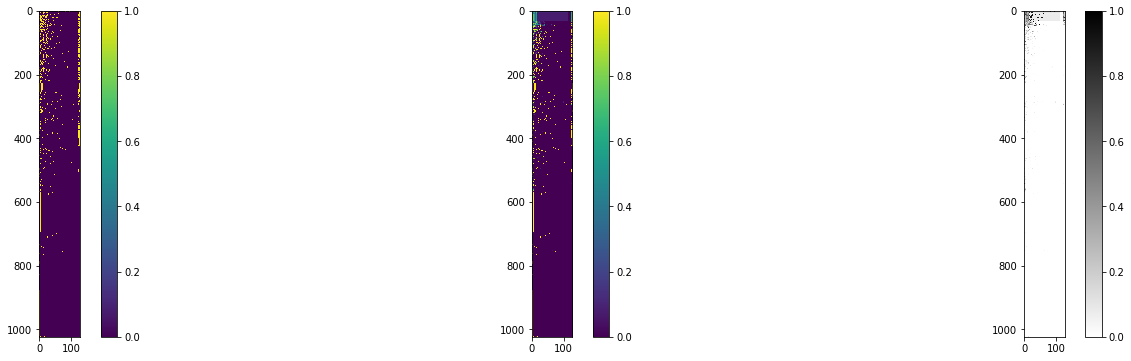

3.4765293e-05
0.9886369


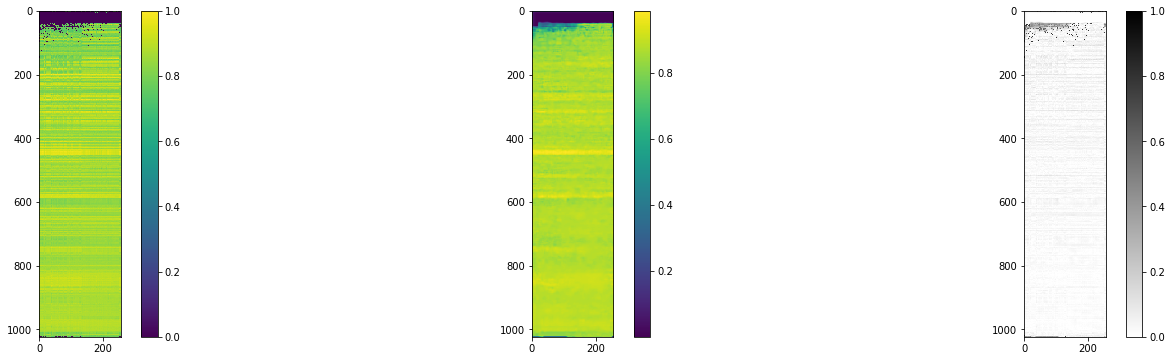

1.1183923e-16
0.5097897


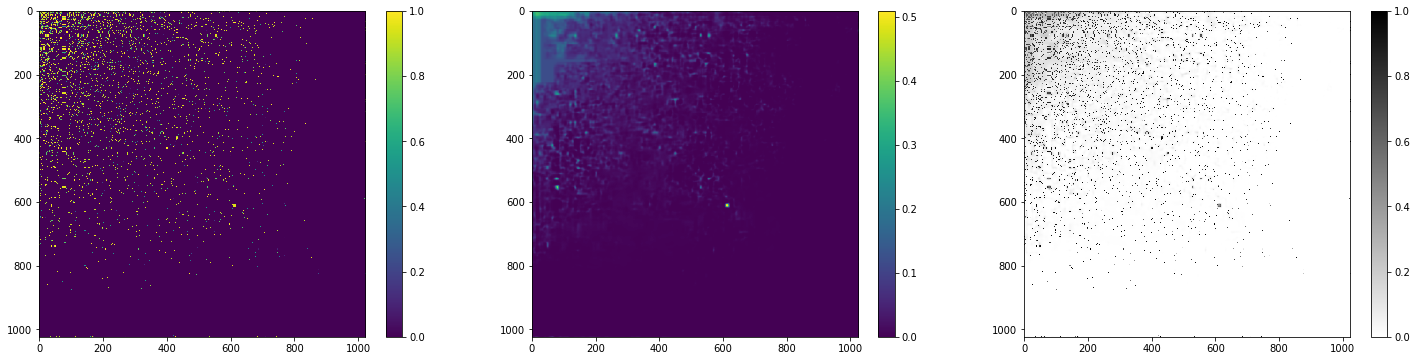

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_50/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


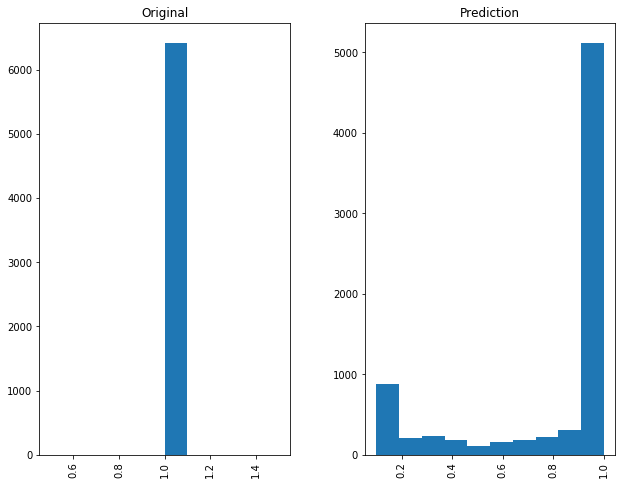

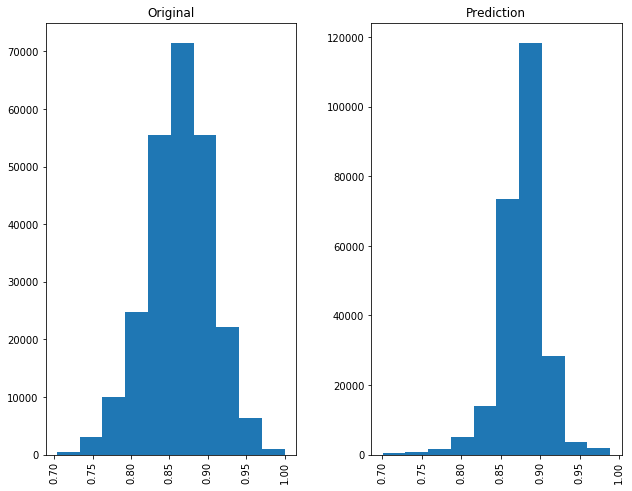

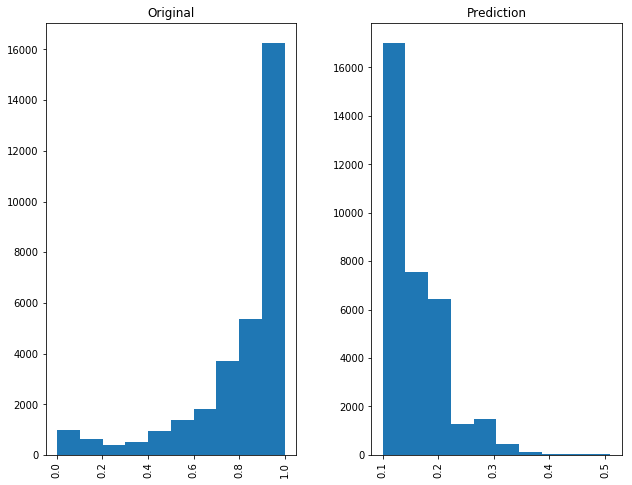

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


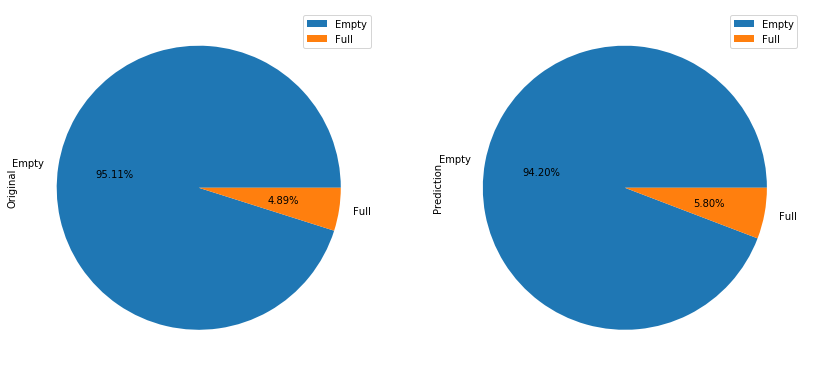

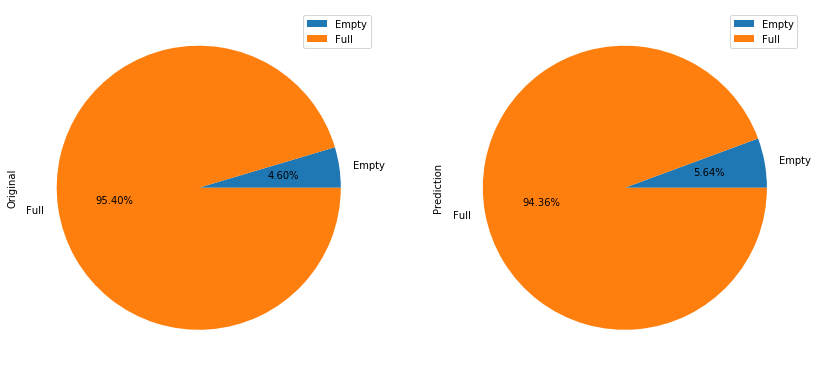

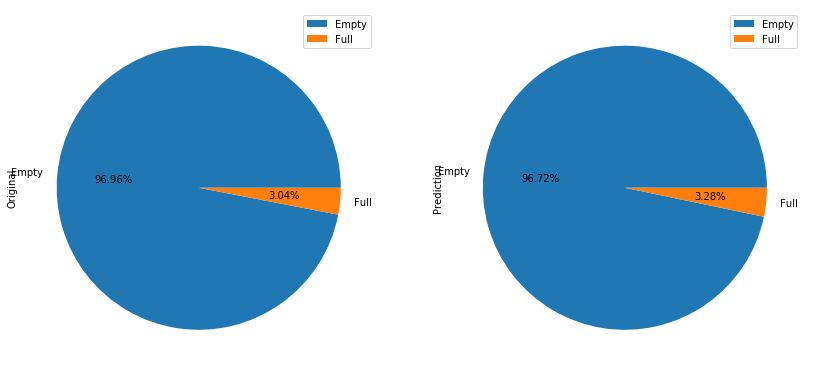

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

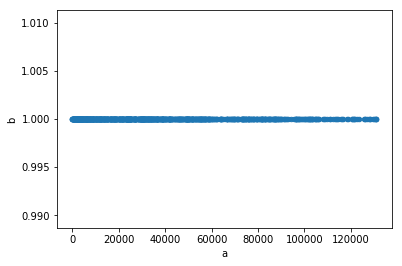

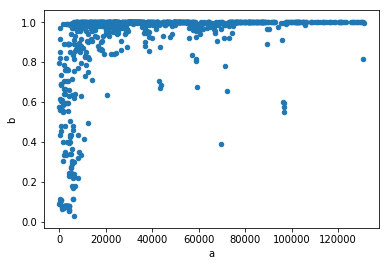

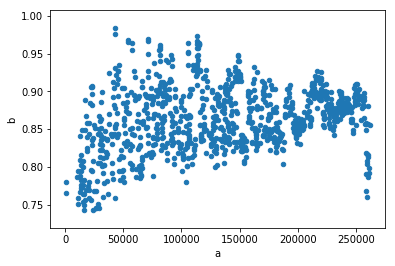

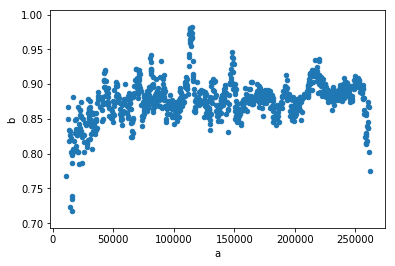

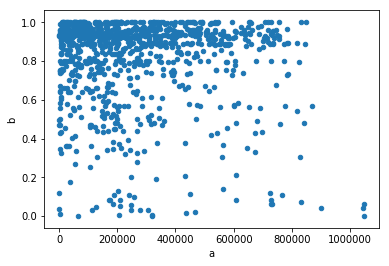

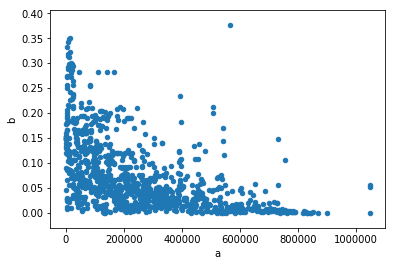

In [8]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

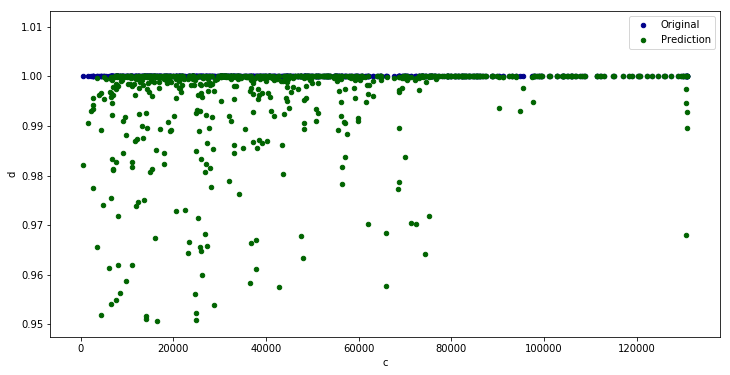

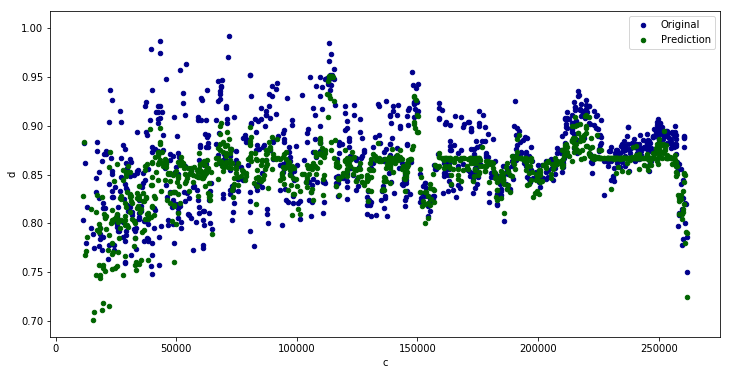

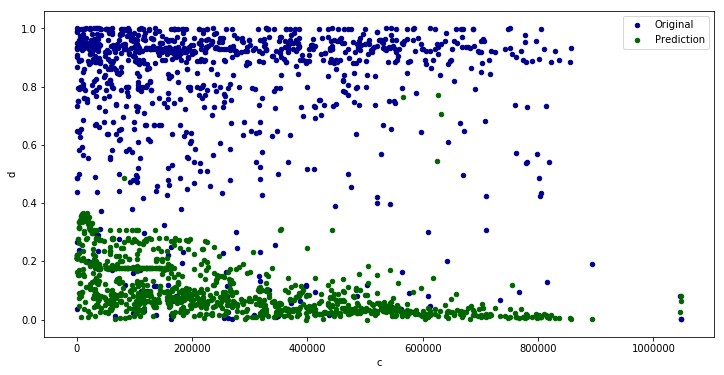

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'scatter_org_vs_prediction_' + str(i) + '.png')

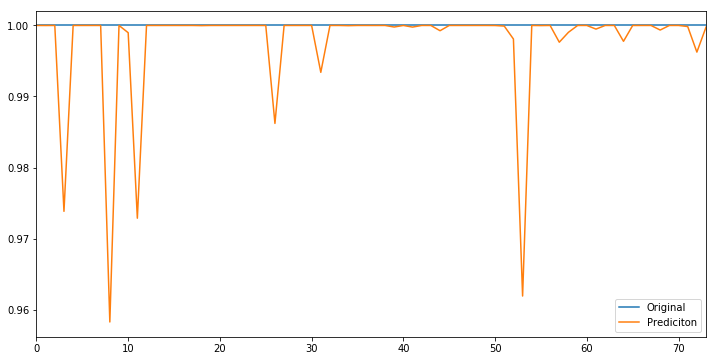

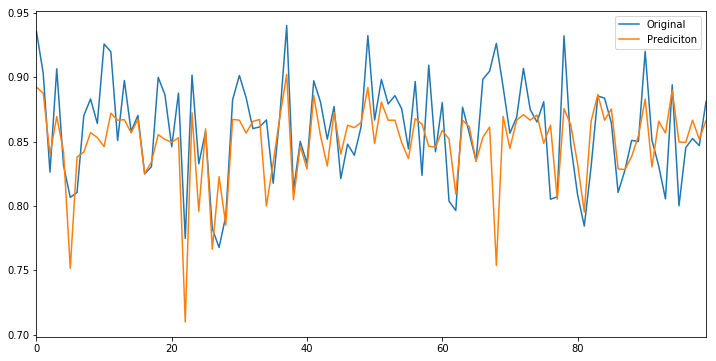

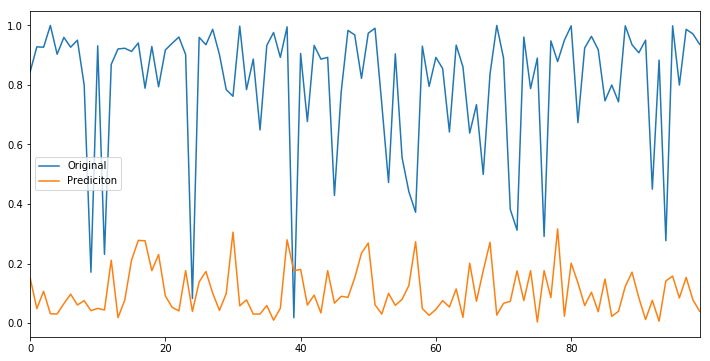

In [11]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))